# CSC5610 Final - Water Potability Analysis (Continued)

Authors: **Jacob Buysse**, **Andrew Cook**, **Josh Grant**

## Part 3 - Geographic Analysis

For this we will be using the following libraries...

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

We will configure our plots for readable labels, high resolution, and automatic layout.

In [3]:
plt.rc("axes", labelsize=18)
plt.rc("figure", dpi=150, autolayout=True)

Let us define a helper function for scoring our models that shows the confusion matrix and the accuracy report.

In [36]:
def score_model(test_y, pred_y):
    print(confusion_matrix(test_y, pred_y))
    print(classification_report(test_y, pred_y))

Let us load our cleaned dataset.

In [5]:
df = pd.read_feather("./potability.feather")
df.head()

,station_id,latitude,longitude,county_name,sample_code,param_(Aminomethyl)phosphonic acid,"param_1,1,1,2-Tetrachloroethane","param_1,1,1-Trichloroethane","param_1,1,2,2-Tetrachloroethane","param_1,1,2-Trichloroethane",...,"param_p,p'-DDE","param_p,p'-DDT",param_p-Xylene,param_pH,"param_s,s,s-Tributyl Phosphorotrithioate (DEF)",param_sec-Butylbenzene,param_tert-Butylbenzene,"param_trans-1,2-Dichloroethene","param_trans-1,3-Dichloropropene",potable
0,1,38.5596,-121.4169,Sacramento,C0114B0005,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,1,38.5596,-121.4169,Sacramento,C0115B0005,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1,38.5596,-121.4169,Sacramento,C0116B0005,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1,38.5596,-121.4169,Sacramento,C0117B0081,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,1,38.5596,-121.4169,Sacramento,C0118B0005,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


For a baseline, let us get an idea of the number of counties we are covering.

In [18]:
print(f"Count of Distinct Counties: {df.county_name.nunique()}")
df.county_name.value_counts()

Count of Distinct Counties: 58


county_name
Los Angeles        37278
San Joaquin        25671
San Bernardino     22613
Ventura            14874
Riverside          13707
Kern               13498
Contra Costa       13391
Sacramento         12152
Santa Clara         9341
Solano              9033
San Diego           8685
Butte               8466
Lake                8321
Orange              8109
Tehama              7824
Shasta              7733
Merced              7197
Fresno              6927
Yolo                6567
Siskiyou            5640
Monterey            5419
Alameda             5302
Sutter              5294
Stanislaus          5094
Humboldt            4908
Lassen              4902
Mendocino           4627
San Luis Obispo     3856
Santa Barbara       3674
Imperial            3570
Tulare              3544
Sonoma              3387
Plumas              3230
Glenn               3146
Modoc               2845
Colusa              2677
Kings               2212
Placer              2211
Santa Cruz          1858
Del Norte    

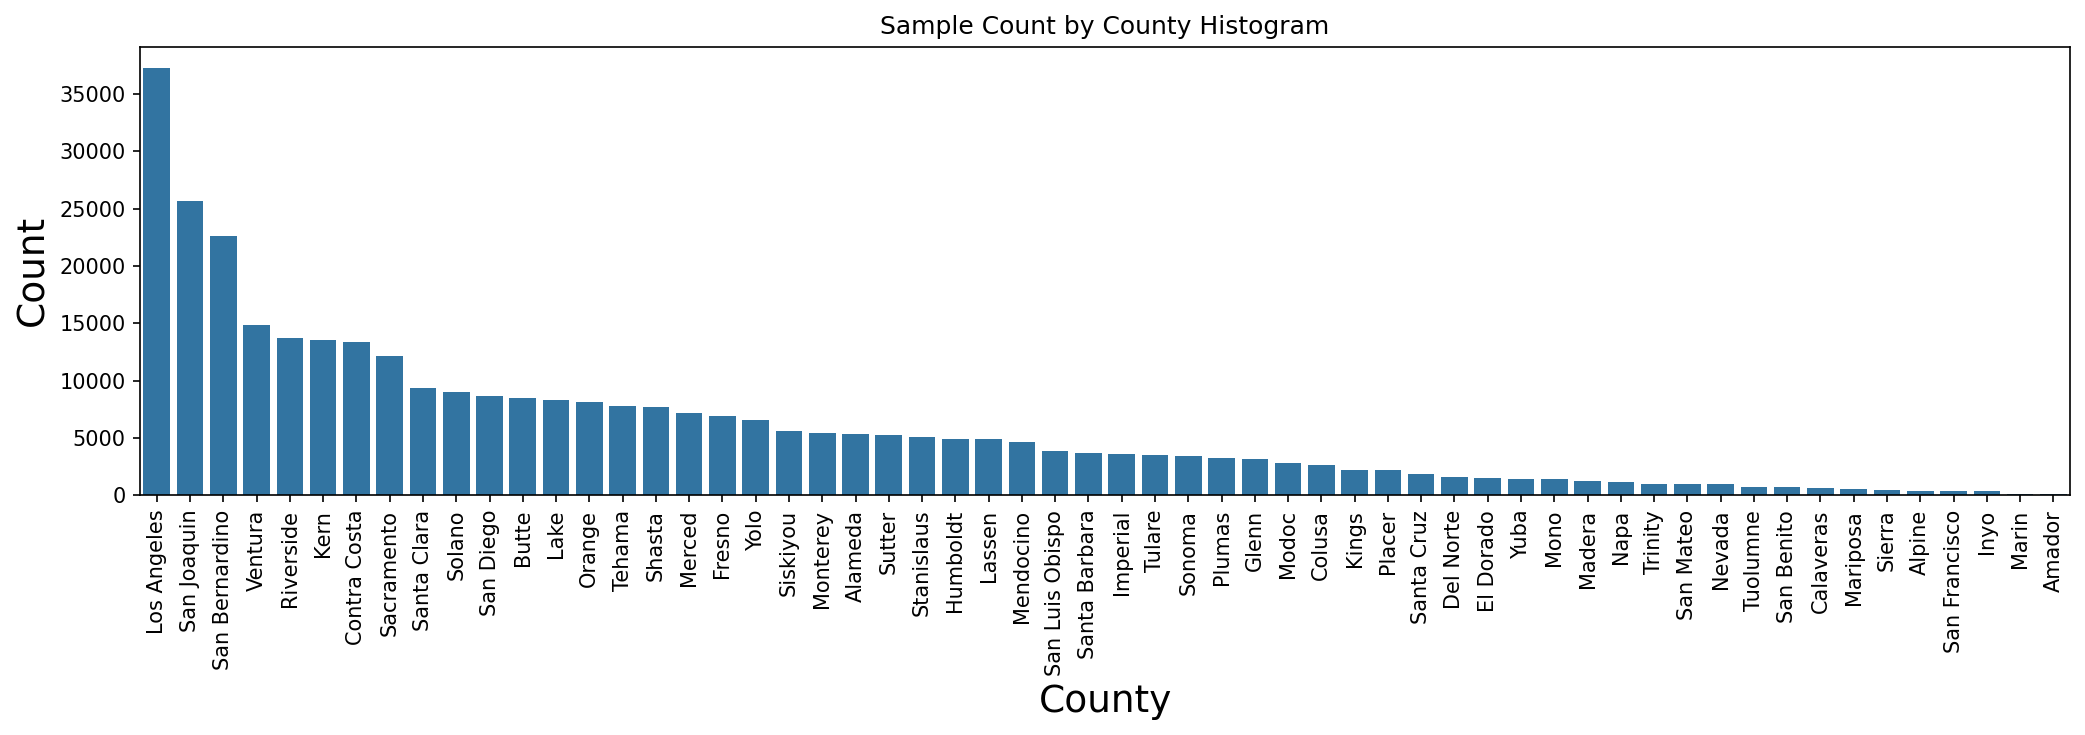

In [30]:
county_counts = df.county_name.value_counts()
_, ax = plt.pyplot.subplots(figsize=(14, 5))
plot = sns.countplot(data=df, x="county_name", ax=ax, order=county_counts.index, color=sns.color_palette()[0])
plot.set(title="Sample Count by County Histogram", xlabel="County", ylabel="Count")
plot.tick_params(axis='x', rotation=90)

Let us look at a scatter plot of of the lat/lon.

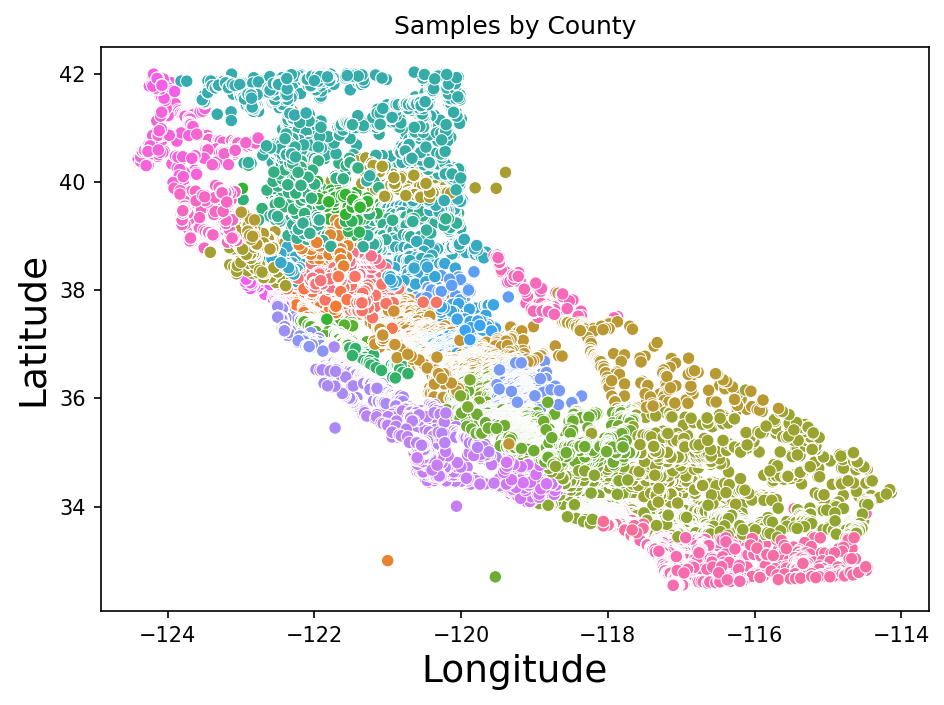

In [10]:
plot = sns.scatterplot(data=df, x="longitude", y="latitude", hue="county_name")
plot.legend_.remove()
plot.set(title="Samples by County", xlabel="Longitude", ylabel="Latitude");

We do appear to have a few outliers - but since we are measuring water quality it is possible to have a station in the ocean.  We won't exclude them but we will remain aware of them in case problems come up later.  Now let us look at a heatmap of the stations.

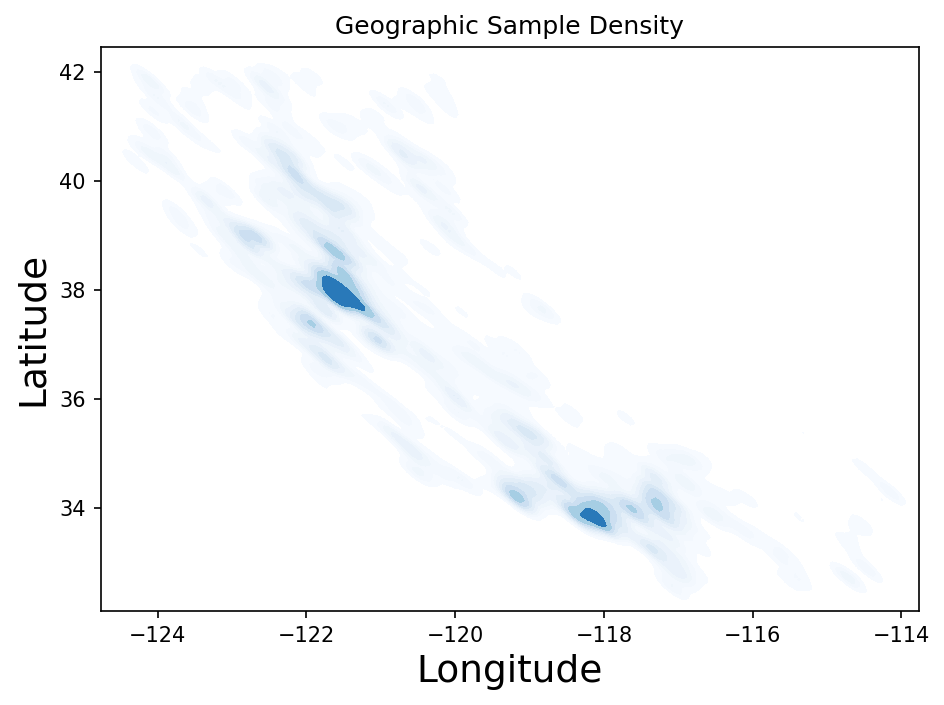

In [11]:
plot = sns.kdeplot(data=df, x="longitude", y="latitude", cmap="Blues", fill=True, bw_adjust=0.5)
plot.set(title="Geographic Sample Density", xlabel="Longitude", ylabel="Latitude");

We can see that we have two regions that contain most of the data.  This would make lat/lon prediction problematic (not enough data in other regions).  A model would likely just predict San Francisco or LA and be right more than half of the time.  Let us do a KMeans classification to see if groups might be a more realistic characteristic to predict.

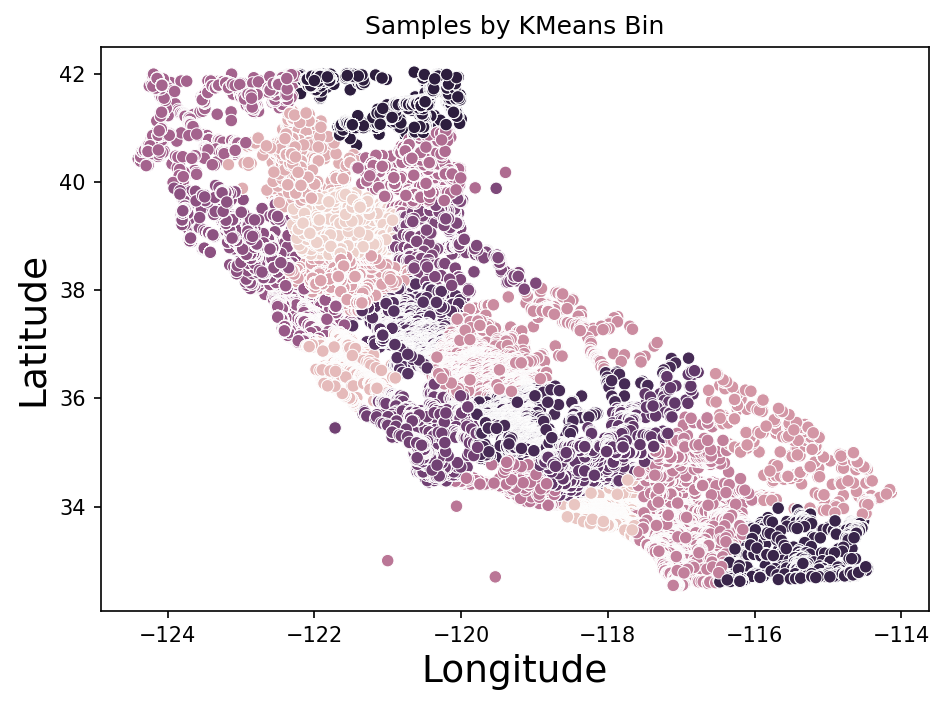

In [23]:
classifier = KMeans(n_init="auto", random_state=777, n_clusters=20)
ll_features = ["latitude", "longitude"]
classifier.fit(df[ll_features])
df["ll_bin"] = classifier.predict(df[ll_features])
plot = sns.scatterplot(data=df, x="longitude", y="latitude", hue=df.ll_bin)
plot.legend_.remove()
plot.set(title="Samples by KMeans Bin", xlabel="Longitude", ylabel="Latitude");

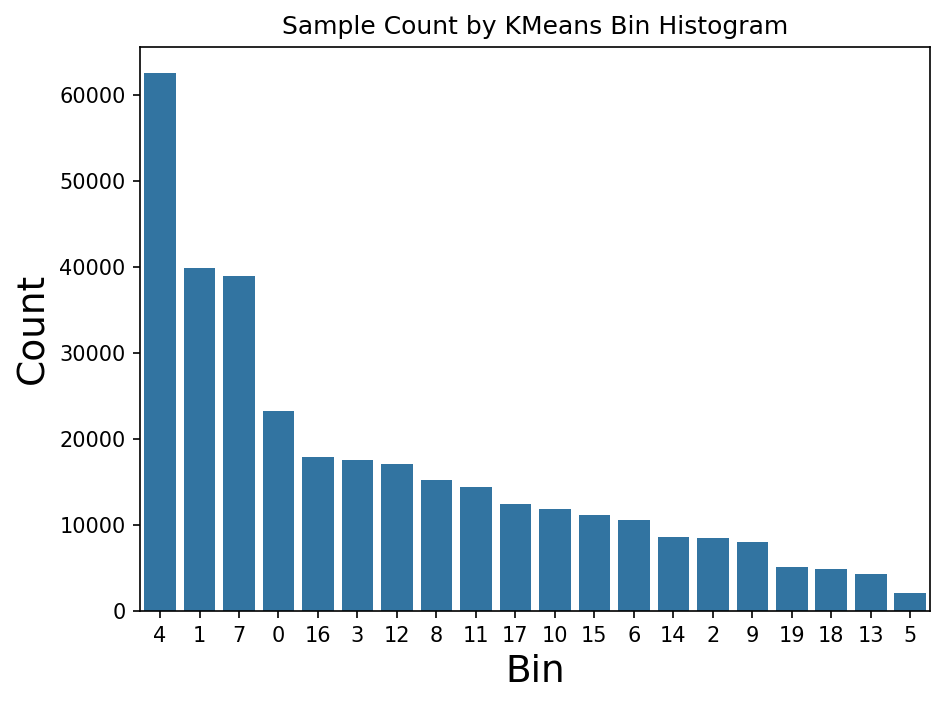

In [29]:
bin_counts = df.ll_bin.value_counts()
plot = sns.countplot(data=df, x="ll_bin", order=bin_counts.index, color=sns.color_palette()[0])
plot.set(title="Sample Count by KMeans Bin Histogram", xlabel="Bin", ylabel="Count");

We can see that we have a much better normal distribution of bins than the original county names.

## Preparing Data for Model Training

Let us prepare our data for training a classification model.

In [31]:
df.ll_bin = df.ll_bin.astype("category")

Now let us split our training and testing datasets stratified on the geographic bin.

In [33]:
train_df, test_df = train_test_split(df, train_size=0.75, random_state=777, stratify=df.ll_bin)
print(f"Train size: {train_df.shape}, Test size: {test_df.shape}")

Train size: (250710, 439), Test size: (83570, 439)


Let us scale our data.

In [34]:
scaler = StandardScaler()
num_features = df.columns[df.columns.str.contains("param_")].values.tolist()
scaler.fit(train_df[num_features])
train_num = scaler.transform(train_df[num_features])
test_num = scaler.transform(test_df[num_features])

We only have numeric features for now, but let us get our train/test X/y values.

In [38]:
train_X = train_num
train_y = train_df.ll_bin.values
test_X = test_num
test_y = test_df.ll_bin.values
print(f"Train X {train_X.shape}, y {len(train_y)}")
print(f"Test X {test_X.shape}, y {len(test_y)}")

Train X (250710, 432), y 250710
Test X (83570, 432), y 83570


Let us try a Decision Tree classifier.

In [39]:
model = DecisionTreeClassifier(random_state=777)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
score_model(test_y, pred_y)

[[ 3798    24    57   412   407     1    83    62    16    98   310    81
    184    41    17    12   132    25     2    59]
 [   30  7634    99    13    78    39    67   973   227    16    28    77
     26     4   130   243    95   106    65    12]
 [   61   118  1086    43   118     1    60    70    33    12    29   154
     41     0    85    47    91    46     5     9]
 [  568    20    44  2206   148     2    80    40     8   100   672    36
    197    53     6     9    97    33     1    75]
 [  446    68   111   147 12722     5   161    89    55    47   105   318
    151    79    46    53   886    78     8    44]
 [    1    40     5     2     1   266     4    76    19     6     0     3
      3     0    10    17    16     6    58     0]
 [   75    62    58    85   146     8  1300    81    16    45    36    37
     31    79    32    50   268   177     9    44]
 [   63   962   106    32   117    81    97  6820   206    33    30    80
     40     6   204   430   178   131   106    19]


We are able to get a 66% accuracy which is higher than I would have guessed.  Now let us try some other models.

In [40]:
model = SGDClassifier(random_state=777, loss="log_loss")
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
score_model(test_y, pred_y)

[[  755  1191     7   546  2829     0     1   270     9     1    22     9
    136     0     2     1    18    19     0     5]
 [    2  6015    10     5   509     0     0  3123   165     0     0    14
     50     0     1     7    26    18    17     0]
 [   42  1168    25    14   397     0     1   358    17     0     6    21
     23     0     1     4     9    21     2     0]
 [  344  1161     1   725  1933     0     1   107     0     0    26     0
     90     0     0     0     3     2     0     2]
 [  136  1424     3   233 13132     0     2   345    10     2     1    85
    111     0     1    44    83     1     2     4]
 [    0   221     0     0    47     1     1   231    27     0     0     4
      0     0     0     0     1     0     0     0]
 [   14   865     5   151  1010     3    40   360    36     2     0    37
     11     0     2     5    26    66     5     1]
 [   12  2345     2    11  1265     0     2  5744   138     1     1     4
     45     1     1    96    53    10    10     0]


SGD only had a 34% accuracy.

In [41]:
model = RandomForestClassifier(random_state=777)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
score_model(test_y, pred_y)

[[ 4462    34    22   303   362     0    32    48     2    16   218    47
    129    31     4     3    78    13     1    16]
 [    5  8764    20     5    24    11     8   833   112     2     0    43
      8     1    30    29    30    27    10     0]
 [   33   118  1397    36    84     0    16   102    18     4    15   126
     28     0    26     6    65    33     1     1]
 [  466    20    14  2765   120     1    29    39     5    18   634    21
    115    20     1     3    54    17     1    52]
 [  333    72    56    83 13813     0    82    91    46    19    67   166
     73    72    24    15   544    41     4    18]
 [    1    29     2     0     1   305     2   130    10     1     0     1
      2     0     6     5     9     4    25     0]
 [   40    81    35    54   118     2  1683   108    11    10    19    15
     21    40    15     8   210   145     5    19]
 [   14   510    21     7    68    13    20  8557    80     9     6    42
     26     2    48   131   112    49    20     6]


Wow.  The Random Forest method was able to increase the accuracy to 77%!